In [ ]:
import torch
from torch import nn

## 1. Make classification date and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles


n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same valuesb

In [ ]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


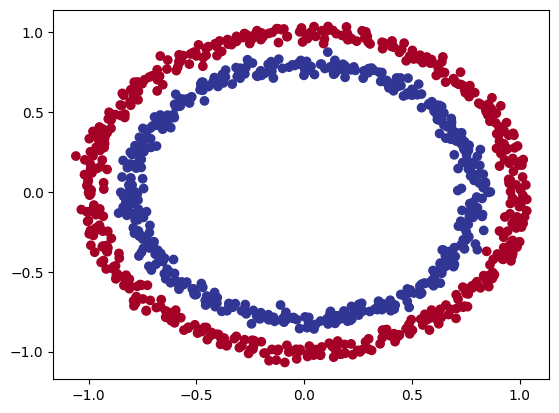

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [ ]:
torch.manual_seed(42)

In [ ]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer

In [ ]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layer that are capable of handling the shapes of our data
3. Defines a forward() method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

        # this way will also work
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=8),
        #     nn.Linear(in_features=8, out_features=1)
        # )

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model0 = CircleModelV0().to(device)
model0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cpu'

In [ ]:
next(model0.parameters()).to(device)

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], requires_grad=True)

In [ ]:
# Replicate CircleModelV0 with nn.Sequential
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [ ]:
# Make predictions
untrained_preds = model0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Lenght of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?
It's problem specific.

F.e. for regression you might want MAE or MSE

For classification you may want binary cross entropy or categorical cross entropy (cross entropy)'

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options

* For the lost function we're going to use `torch.nn.BECWithLogitsLoss()`
* For different optimizers see `torch.optim`

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Train model

To train our model we have to build a training loop

### 3.1 Going from raw logits to prediction probabilities to predictions labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of
activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [ ]:
# See the first 5 outputs of the dorward pass on the test data
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]

y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# USe the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs < 0.5`, y=1
else: y=0

In [ ]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building training and the testing loop

In [ ]:
torch.manual_seed(42)
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model0.train()
  ### training
  model0.train()

  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logids into pred probs then to pred labels

  ### Calculate the accuracy

  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  optimizer.step() # gradient descent


  ### testing
  model0.eval()
  with torch.inference_mode():
    # 1.forward pass
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69796% | Test loss: 0.69440 | Test acc: 58.00%
Epoch: 10 | Loss: 0.69590% | Test loss: 0.69305 | Test acc: 53.00%
Epoch: 20 | Loss: 0.69490% | Test loss: 0.69254 | Test acc: 49.50%
Epoch: 30 | Loss: 0.69435% | Test loss: 0.69236 | Test acc: 49.50%
Epoch: 40 | Loss: 0.69401% | Test loss: 0.69232 | Test acc: 51.00%
Epoch: 50 | Loss: 0.69378% | Test loss: 0.69234 | Test acc: 50.00%
Epoch: 60 | Loss: 0.69362% | Test loss: 0.69239 | Test acc: 51.50%
Epoch: 70 | Loss: 0.69351% | Test loss: 0.69246 | Test acc: 51.00%
Epoch: 80 | Loss: 0.69342% | Test loss: 0.69254 | Test acc: 50.00%
Epoch: 90 | Loss: 0.69336% | Test loss: 0.69262 | Test acc: 53.00%


## 4. Make predictions and evaluate the model

From the metric it looks like our model isn't learning anything

In [ ]:
import requests
from pathlib import Path

# Download the helper functions from learn pytoech repo
if Path("helper_functions.py").is_file():
  print("helper_function.py aready exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


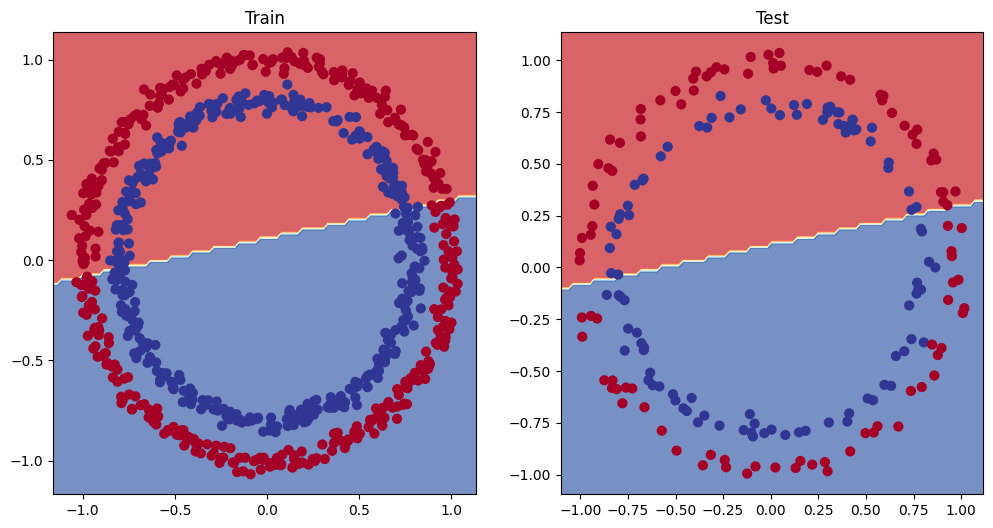

In [ ]:
# PLot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # (row, column, index)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

## 5. Improving a model
* Add more layers - give the mdel more chances to learn
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* changing the activation functions
* Change the learning rate
* Change the loss function

These options are from model's perspective, you can also improve the model from the data perspective.

And because these options are all values we can change, they are referred as **hyperparameters**

In [ ]:
class CircleModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer1(x)
    # z = self.layer2(z)
    # z = self.layer3(z)
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModel1().to(device)
model1

CircleModel1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create loss fucntion

loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)


In [ ]:
torch.manual_seed(42)
epochs = 1000
X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

for epoch in range(epochs):
  model1.train()

  y_logits = model1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward() # backpropagation
  optimizer.step() # gradient descent

  ### Testing
  model1.eval()
  with torch.inference_mode():
    # Do the forward pass
    test_logits = model1(X_test).squeeze()
    test_pred =  torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}% | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396% | Acc: 49.38% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69305% | Acc: 49.38% | Test loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299% | Acc: 49.38% | Test loss: 0.69437 | Test acc: 46.00%
Epoch: 300 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69458 | Test acc: 45.00%
Epoch: 400 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69465 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69467 | Test acc: 46.00%
Epoch: 600 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 700 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 800 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 900 | Loss: 0.69298% | Acc: 49.38% | Test loss: 0.69468 | Test acc: 46.00%


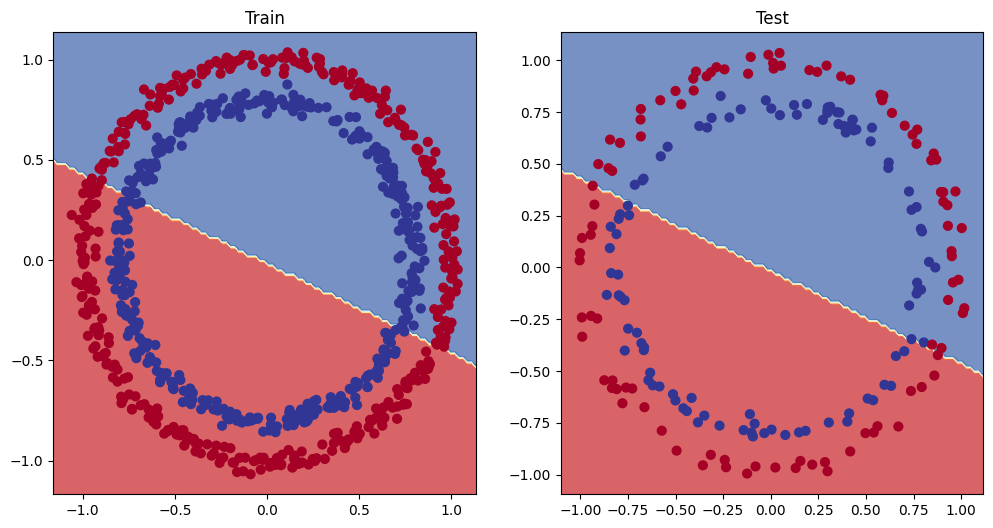

In [ ]:
# PLot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # (row, column, index)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

### 5.1 Preaparing data to see if our model can fit a straight line

One way to troubleshoot is to test on smaller problem

In [ ]:
weight = .7
bias = .3
start = 0
end = 1
step = .01

# Xreate data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits
train_split = int(.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


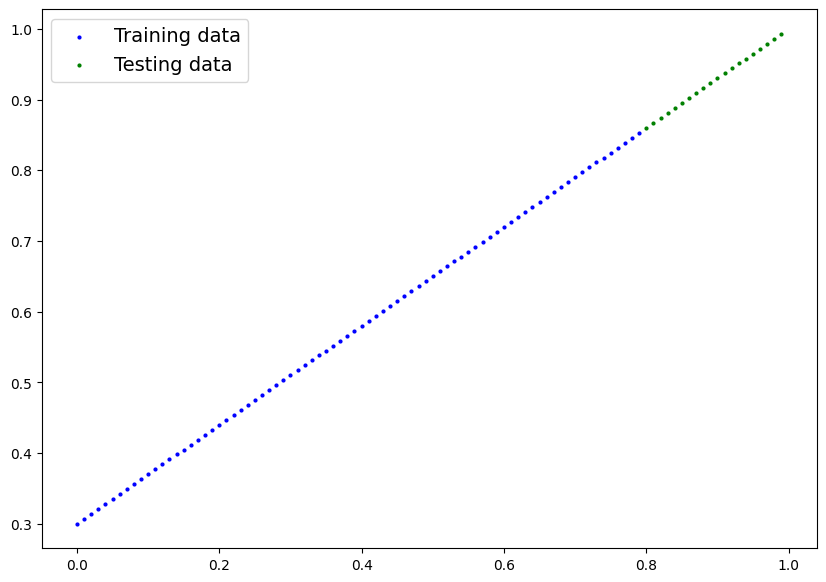

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
### 5.2 Adjusting `model1` to fit a straight line

In [ ]:
X_train_regression[:10]

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])

In [ ]:
# Same architectura as model1 but usinf nn.sequential()
model2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model2.parameters(),
                             lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)

epochs = 1000

X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)

# Train
for epoch in range(epochs):
  y_pred = model2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model2.eval()
  with torch.inference_mode():
    test_pred = model2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


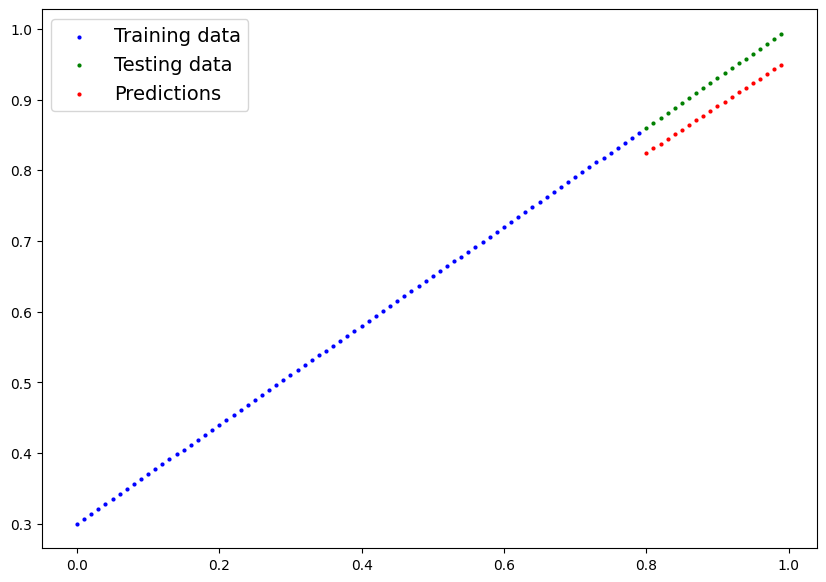

In [ ]:
# Turn on evaluation mode
model2.eval()

with torch.inference_mode():
  y_preds = model2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines"

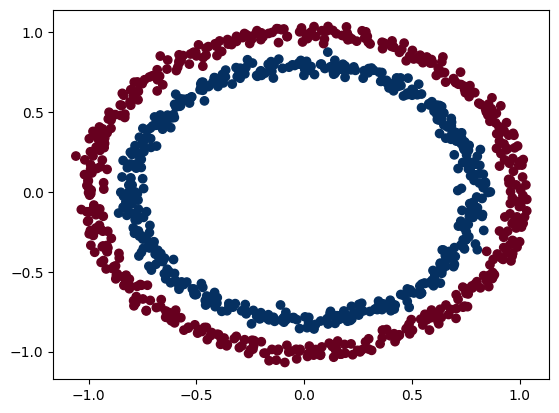

In [ ]:
### 6.1 Recreating non-linear data (red and blue circles)
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [ ]:
# Convert data to tensors and then to train and test split
import torch
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### 6.2 Building a model with non-linearity

In [ ]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model3 = CircleModelV2().to(device)
print(model3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [ ]:
# Fit the model
torch.manual_seed(42)
epochs = 10000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88% | Test Loss: 0.06583, Test Accuracy: 100.00%
Epoch: 3000 | Loss: 0.01672, Accuracy: 99.88% | Test Loss: 0.03363, Test Accuracy: 100.00%
Epoch: 4000 | Loss: 0.01048, Accuracy: 100.00% | Test Loss: 0.02451, Test Accuracy: 99.50%
Epoch: 5000 | Loss: 0.00765, Accuracy: 100.00% | Test Loss: 0.01993, Test Accuracy: 99.50%
Epoch: 6000 | Loss: 0.00603, Accuracy: 100.00% | Test Loss: 0.01726, Test Accuracy: 99.50%
Epoch: 7000 | Loss: 0.00499, Accuracy: 100.00% | Test Loss: 0.01557, Test Accuracy: 99.50%
Epoch: 8000 | Loss: 0.00428, Accuracy: 100.00% | Test Loss: 0.01451, Test Accuracy: 99.50%
Epoch: 9000 | Loss: 0.00375, Accuracy: 100.00% | Test Loss: 0.01374, Test Accuracy: 99.50%


In [ ]:
plot_predictions()

TypeError: ignored

In [ ]:
### 6.4 Evaluating a model trained with non-linear activation functions
model3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))